In [1]:
# !pip install -U gluonts pytorch-lightning torch

In [58]:
%matplotlib inline

In [69]:
from typing import List, Optional, Iterable, Dict, Any, Tuple
from itertools import islice
import queue

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import tqdm.auto as tqdm
from datasets import load_dataset

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import _LRScheduler, MultiplicativeLR
from torch.optim import Optimizer

import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger

from gluonts.core.component import validated
from gluonts.dataset.common import Dataset, ListDataset
from gluonts.dataset.field_names import FieldName
from gluonts.itertools import Cyclic, PseudoShuffled, IterableSlice
from gluonts.time_feature import (
    TimeFeature,
    time_features_from_frequency_str,
)
from gluonts.torch.modules.loss import DistributionLoss, NegativeLogLikelihood
from gluonts.transform import (
    Transformation,
    Chain,
    RemoveFields,
    SetField,
    AsNumpyArray,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AddAgeFeature,
    VstackFeatures,
    InstanceSplitter,
    ValidationSplitSampler,
    TestSplitSampler,
    ExpectedNumInstanceSampler,
    SelectFields,
)
from gluonts.torch.util import (
    IterableDataset,
)
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.torch.model.estimator import PyTorchLightningEstimator
from gluonts.torch.model.predictor import PyTorchPredictor
from gluonts.torch.distributions import (
    DistributionOutput,
    StudentTOutput,
)
from gluonts.torch.util import weighted_average
from gluonts.torch.modules.scaler import MeanScaler, NOPScaler
from gluonts.torch.modules.feature import FeatureEmbedder
from gluonts.time_feature import get_lags_for_frequency
from gluonts.dataset.repository.datasets import get_dataset

In [60]:
from s4 import S4

In [61]:
class S4Model(nn.Module):
    def __init__(
        self,
        freq: str,
        
        context_length: int,
        prediction_length: int,
        
        num_feat_dynamic_real: int,
        num_feat_static_real: int,
        
        num_feat_static_cat: int,
        cardinality: List[int],
        embedding_dimension: Optional[List[int]] = None,
        
        input_size: int = 1, # univariate input
        
        # S4 inputs
        d_state: int = 64,
        nhead: int = 1, #  channels: can be interpreted as a number of "heads"
        num_layers: int = 1, # Number of layers
        dropout_rate: float = 0.2,
        prenorm: bool = False, # Prenorm
        activation: str = "gelu",  # activation in between SS and FF
        postact: str = "glu",  # activation after FF
        measure: str = "legs",
        trainable: Optional[Dict[str, bool]] = None,
        
        distr_output: DistributionOutput = StudentTOutput(),
        lags_seq: Optional[List[int]] = None,
        scaling: bool = True,
        num_parallel_samples: int = 100,
    ) -> None:
        super().__init__()
        self.context_length = context_length
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.target_shape = distr_output.event_shape
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.embedding_dimension = (
            embedding_dimension
            if embedding_dimension is not None or cardinality is None
            else [min(50, (cat + 1) // 2) for cat in cardinality]
        )
        self.lags_seq = lags_seq or get_lags_for_frequency(freq_str=freq)
        self.num_parallel_samples = num_parallel_samples
        
        self.embedder = FeatureEmbedder(
            cardinalities=cardinality,
            embedding_dims=self.embedding_dimension,
        )
        if scaling:
            self.scaler = MeanScaler(dim=1, keepdim=True)
        else:
            self.scaler = NOPScaler(dim=1, keepdim=True)
        
        self.lagged_s4 = LaggedS4(
            input_size=input_size,
            features_size=self._number_of_features,
            lags_seq=[lag - 1 for lag in self.lags_seq],
            
            # S4 inputs
            d_state=d_state,
            channels=nhead,
            prenorm=prenorm,
            activation=activation,
            postact=postact,
            num_layers=num_layers,
            dropout=dropout_rate,
            #l_max=self._past_length + self.prediction_length,
            measure=measure,
            trainable=trainable,
        )
        
        self.param_proj = distr_output.get_args_proj(input_size*len(self.lags_seq) + self._number_of_features)


    @property
    def _number_of_features(self) -> int:
        return (
            sum(self.embedding_dimension)
            + self.num_feat_dynamic_real
            + self.num_feat_static_real
            + 1  # the log(scale)
        )
    
    @property
    def _past_length(self) -> int:
        return self.context_length + max(self.lags_seq)

    def unroll_lagged_s4(
        self,
        feat_static_cat: torch.Tensor,
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: Optional[torch.Tensor] = None,
        future_target: Optional[torch.Tensor] = None,
        state: Optional[torch.Tensor] = None,
    ) -> Tuple[
        Tuple[torch.Tensor, ...],
        torch.Tensor,
        torch.Tensor,
        torch.Tensor,
        Tuple[torch.Tensor, torch.Tensor],
    ]:
        context = past_target[:, -self.context_length :]
        observed_context = past_observed_values[:, -self.context_length :]
        _, scale = self.scaler(context, observed_context)

        prior_input = past_target[:, : -self.context_length] / scale
        inputs = (
            torch.cat((context, future_target[:, :-1]), dim=1) / scale
            if future_target is not None
            else context / scale
        )

        unroll_length = (
            self.context_length
            if future_target is None
            else self.context_length + future_target.shape[1] - 1
        )
        assert inputs.shape[1] == unroll_length

        embedded_cat = self.embedder(feat_static_cat)
        static_feat = torch.cat(
            (embedded_cat, feat_static_real, scale.log()),
            dim=1,
        )
        expanded_static_feat = static_feat.unsqueeze(1).expand(
            -1, unroll_length, -1
        )

        time_feat = (
            torch.cat(
                (
                    past_time_feat[:, -self.context_length + 1 :, ...],
                    future_time_feat,
                ),
                dim=1,
            )
            if future_time_feat is not None
            else past_time_feat[:, -self.context_length + 1 :, ...]
        )

        features = torch.cat((expanded_static_feat, time_feat), dim=-1)

        output, new_state = self.lagged_s4(prior_input, inputs, features, state)

        params = self.param_proj(output)
        return params, scale, output, static_feat, new_state

    @torch.jit.ignore
    def output_distribution(
        self, params, scale=None, trailing_n=None
    ) -> torch.distributions.Distribution:
        sliced_params = params
        if trailing_n is not None:
            sliced_params = [p[:, -trailing_n:] for p in params]
        return self.distr_output.distribution(sliced_params, scale=scale)

    # prediction
    def forward(
        self,
        feat_static_cat: torch.Tensor,
        feat_static_real: torch.Tensor,
        past_time_feat: torch.Tensor,
        past_target: torch.Tensor,
        past_observed_values: torch.Tensor,
        future_time_feat: torch.Tensor,
        num_parallel_samples: Optional[int] = None,
    ) -> torch.Tensor:
        if num_parallel_samples is None:
            num_parallel_samples = self.num_parallel_samples
            
        for layer in self.lagged_s4.s4_layers:
            layer.kernel.kernel.setup_step()
            default_state = layer.kernel.default_state(*past_target.shape[:1])
            
        params, scale, _, static_feat, state = self.unroll_lagged_s4(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
            future_time_feat[:, :1],
            state=default_state,
        )

        repeated_scale = scale.repeat_interleave(
            repeats=num_parallel_samples, dim=0
        )
        
        repeated_static_feat = static_feat.repeat_interleave(
            repeats=num_parallel_samples, dim=0
        ).unsqueeze(dim=1)
        
        repeated_past_target = (
            past_target.repeat_interleave(
                repeats=num_parallel_samples, dim=0
            )
            / repeated_scale
        )
        
        repeated_time_feat = future_time_feat.repeat_interleave(
            repeats=num_parallel_samples, dim=0
        )
        
        repeated_state = state.repeat_interleave(repeats=num_parallel_samples, dim=0)
        
        repeated_params = [
            s.repeat_interleave(repeats=num_parallel_samples, dim=0)
            for s in params
        ]
        
        distr = self.output_distribution(
            repeated_params, trailing_n=1, scale=repeated_scale
        )
        next_sample = distr.sample()
        future_samples = [next_sample]
        
        for k in range(1, self.prediction_length):
            scaled_next_sample = next_sample / repeated_scale
            next_features = torch.cat(
                (repeated_static_feat, repeated_time_feat[:, k : k + 1]),
                dim=-1,
            )

            output, repeated_state = self.lagged_s4(
                repeated_past_target,
                scaled_next_sample,
                next_features,
                repeated_state,
                step=True,
            )

            repeated_past_target = torch.cat(
                (repeated_past_target, scaled_next_sample), dim=1
            )

            params = self.param_proj(output)
            
            # hack: sometimes the params ie. output has nans
            # replace nans with means of the params...
            # params = [p.nan_to_num(nan=p.nanmean(0).item()) for p in params]
            
            distr = self.output_distribution(params, scale=repeated_scale)
            next_sample = distr.sample()
            future_samples.append(next_sample)

        future_samples_concat = torch.cat(future_samples, dim=1)

        return future_samples_concat.reshape(
            (-1, self.num_parallel_samples, self.prediction_length)
            + self.target_shape,
        )

In [62]:
class LaggedS4(nn.Module):
    def __init__(
        self,
        input_size: int,
        features_size: int,
        lags_seq: List[int],
        
        #s4 inputs
        d_state: int = 64,
        channels: int = 1, #  channels: can be interpreted as a number of "heads"
        num_layers: int = 1, # Number of layers
        l_max: int = 1, # max length or 1
        dropout: float = 0.2,
        prenorm: bool = False, # Prenorm flag
        activation: str = "gelu",  # activation in between SS and FF
        postact: str = "glu",  # activation after FF
        measure: str = "fourier",
        trainable: Optional[Dict[str, bool]] = None,
    ) -> None:
        super().__init__()
        self.input_size = input_size
        self.features_size = features_size
        self.lags_seq = lags_seq
        
        d_model = input_size * len(self.lags_seq) + features_size
        self.prenorm = prenorm
        
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(num_layers):
            self.s4_layers.append(
                S4(
                    d_model=d_model,
                    d_state=d_state,
                    l_max=l_max,
                    channels=channels,
                    activation=activation,
                    dropout=dropout,
                    transposed=False, #[B, T, F]
                    postact=postact,
                    measure=measure,
                    trainable=trainable,
                    mode="nplr",
                    n_ssm=1,
                )
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(nn.Dropout2d(dropout))

    def get_lagged_subsequences(
        self,
        sequence: torch.Tensor,
        subsequences_length: int,
    ) -> torch.Tensor:
        """
        Returns lagged subsequences of a given sequence.
        Parameters
        ----------
        sequence : Tensor
            the sequence from which lagged subsequences should be extracted.
            Shape: (N, T, C).
        subsequences_length : int
            length of the subsequences to be extracted.
        Returns
        --------
        lagged : Tensor
            a tensor of shape (N, S, C, I), where S = subsequences_length and
            I = len(indices), containing lagged subsequences. Specifically,
            lagged[i, j, :, k] = sequence[i, -indices[k]-S+j, :].
        """
        sequence_length = sequence.shape[1]
        indices = self.lags_seq

        assert max(indices) + subsequences_length <= sequence_length, (
            f"lags cannot go further than history length, found lag {max(indices)} "
            f"while history length is only {sequence_length}"
        )

        lagged_values = []
        for lag_index in indices:
            begin_index = -lag_index - subsequences_length
            end_index = -lag_index if lag_index > 0 else None
            lagged_values.append(sequence[:, begin_index:end_index, ...])
        return torch.stack(lagged_values, dim=-1)

    def _check_shapes(
        self,
        prior_input: torch.Tensor,
        input: torch.Tensor,
        features: Optional[torch.Tensor],
    ) -> None:
        assert len(prior_input.shape) == len(input.shape)
        assert (
            len(prior_input.shape) == 2 and self.input_size == 1
        ) or prior_input.shape[2] == self.input_size
        assert (len(input.shape) == 2 and self.input_size == 1) or input.shape[
            -1
        ] == self.input_size
        assert (
            features is None or features.shape[2] == self.features_size
        ), f"{features.shape[2]}, expected {self.features_size}"

    def forward(
        self,
        prior_input: torch.Tensor,
        inputs: torch.Tensor,
        features: Optional[torch.Tensor] = None,
        state: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,
        step: bool = False,
    ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        self._check_shapes(prior_input, inputs, features)

        sequence = torch.cat((prior_input, inputs), dim=1)
        lagged_sequence = self.get_lagged_subsequences(
            sequence=sequence,
            subsequences_length=inputs.shape[1],
        )

        lags_shape = lagged_sequence.shape
        reshaped_lagged_sequence = lagged_sequence.reshape(
            lags_shape[0], lags_shape[1], -1
        )

        if features is None:
            s4_input = reshaped_lagged_sequence
        else:
            s4_input = torch.cat((reshaped_lagged_sequence, features), dim=-1)

        x = s4_input
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z)
            
            if step:
                z, state = layer.step(z.squeeze(), state)
                z = z.unsqueeze(1)
            else:
                # Apply S4 block
                z, state = layer(z, state)
            
            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x)

        return x, state

In [63]:
class S4LightningModule(pl.LightningModule):
    def __init__(
        self,
        model: S4Model,
        loss: DistributionLoss = NegativeLogLikelihood(),
        lr: float = 1e-3,
        weight_decay: float = 1e-8,
    ) -> None:
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.loss = loss
        self.lr = lr
        self.weight_decay = weight_decay

    def _compute_loss(self, batch):
        feat_static_cat = batch["feat_static_cat"]
        feat_static_real = batch["feat_static_real"]
        past_time_feat = batch["past_time_feat"]
        past_target = batch["past_target"]
        future_time_feat = batch["future_time_feat"]
        future_target = batch["future_target"]
        past_observed_values = batch["past_observed_values"]
        future_observed_values = batch["future_observed_values"]

        params, scale, _, _, _ = self.model.unroll_lagged_s4(
            feat_static_cat,
            feat_static_real,
            past_time_feat,
            past_target,
            past_observed_values,
            future_time_feat,
            future_target,
        )
        distr = self.model.output_distribution(params, scale)

        context_target = past_target[:, -self.model.context_length + 1 :]
        target = torch.cat(
            (context_target, future_target),
            dim=1,
        )
        loss_values = self.loss(distr, target)

        context_observed = past_observed_values[
            :, -self.model.context_length + 1 :
        ]
        observed_values = torch.cat(
            (context_observed, future_observed_values), dim=1
        )

        if len(self.model.target_shape) == 0:
            loss_weights = observed_values
        else:
            loss_weights, _ = observed_values.min(dim=-1, keepdim=False)

        return weighted_average(loss_values, weights=loss_weights)

    def training_step(self, batch, batch_idx: int):  # type: ignore
        """Execute training step"""
        train_loss = self._compute_loss(batch)
        self.log(
            "train_loss",
            train_loss,
            on_epoch=True,
            on_step=False,
            prog_bar=True,
        )
        return train_loss

    def validation_step(self, batch, batch_idx: int):  # type: ignore
        """Execute validation step"""
        with torch.no_grad():
            val_loss = self._compute_loss(batch)
        self.log(
            "val_loss", val_loss, on_epoch=True, on_step=False, prog_bar=True
        )
        return val_loss

    def configure_optimizers(self):
        """Returns the optimizer to use"""
        return torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
            weight_decay=self.weight_decay,
        )

In [64]:
PREDICTION_INPUT_NAMES = [
    "feat_static_cat",
    "feat_static_real",
    "past_time_feat",
    "past_target",
    "past_observed_values",
    "future_time_feat",
]

TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
    "future_target",
    "future_observed_values",
]

In [65]:
class S4Estimator(PyTorchLightningEstimator):
    def __init__(
        self,
        freq: str,
        prediction_length: int,
        context_length: Optional[int] = None,

        d_state: int = 64,
        num_layers: int = 2,
        nhead: int = 2,
        prenorm: bool = False,
        activation: str = "gelu",
        postact: str = "glu",
        dropout_rate: float = 0.1,
        measure: str = "fourier",
        trainable: Optional[Dict[str, bool]] = None,
        
        num_feat_dynamic_real: int = 0,
        num_feat_static_cat: int = 0,
        num_feat_static_real: int = 0,
        cardinality: Optional[List[int]] = None,
        embedding_dimension: Optional[List[int]] = None,
        distr_output: DistributionOutput = StudentTOutput(),
        loss: DistributionLoss = NegativeLogLikelihood(),
        scaling: bool = True,
        lags_seq: Optional[List[int]] = None,
        time_features: Optional[List[TimeFeature]] = None,
        num_parallel_samples: int = 100,
        batch_size: int = 32,
        num_batches_per_epoch: int = 50,
        trainer_kwargs: Optional[Dict[str, Any]] = None,
    ) -> None:
        default_trainer_kwargs = {
            "max_epochs": 100,
            #"gradient_clip_val": 10.0,
        }
        if trainer_kwargs is not None:
            default_trainer_kwargs.update(trainer_kwargs)
        super().__init__(trainer_kwargs=default_trainer_kwargs)

        self.freq = freq
        self.context_length = (
            context_length if context_length is not None else prediction_length
        )
        self.prediction_length = prediction_length
        self.distr_output = distr_output
        self.loss = loss
        
        self.d_state = d_state
        self.num_layers = num_layers
        self.nhead = nhead
        self.activation = activation
        self.prenorm = prenorm
        self.postact = postact
        self.measure = measure
        self.trainable = trainable
        
        self.dropout_rate = dropout_rate
        self.num_feat_dynamic_real = num_feat_dynamic_real
        self.num_feat_static_cat = num_feat_static_cat
        self.num_feat_static_real = num_feat_static_real
        self.cardinality = (
            cardinality if cardinality and num_feat_static_cat > 0 else [1]
        )
        self.embedding_dimension = embedding_dimension
        self.scaling = scaling
        self.lags_seq = lags_seq
        self.time_features = (
            time_features
            if time_features is not None
            else time_features_from_frequency_str(self.freq)
        )

        self.num_parallel_samples = num_parallel_samples
        self.batch_size = batch_size
        self.num_batches_per_epoch = num_batches_per_epoch

        self.train_sampler = ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=prediction_length
        )
        self.validation_sampler = ValidationSplitSampler(
            min_future=prediction_length
        )

    def create_transformation(self) -> Transformation:
        remove_field_names = []
        if self.num_feat_static_real == 0:
            remove_field_names.append(FieldName.FEAT_STATIC_REAL)
        if self.num_feat_dynamic_real == 0:
            remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

        return Chain(
            [RemoveFields(field_names=remove_field_names)]
            + (
                [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
                if not self.num_feat_static_cat > 0
                else []
            )
            + (
                [
                    SetField(
                        output_field=FieldName.FEAT_STATIC_REAL, value=[0.0]
                    )
                ]
                if not self.num_feat_static_real > 0
                else []
            )
            + [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                ),
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                ),
                AsNumpyArray(
                    field=FieldName.TARGET,
                    # in the following line, we add 1 for the time dimension
                    expected_ndim=1 + len(self.distr_output.event_shape),
                ),
                AddObservedValuesIndicator(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.OBSERVED_VALUES,
                ),
                AddTimeFeatures(
                    start_field=FieldName.START,
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_TIME,
                    time_features=self.time_features,
                    pred_length=self.prediction_length,
                ),
                AddAgeFeature(
                    target_field=FieldName.TARGET,
                    output_field=FieldName.FEAT_AGE,
                    pred_length=self.prediction_length,
                    log_scale=True,
                ),
                VstackFeatures(
                    output_field=FieldName.FEAT_TIME,
                    input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                    + (
                        [FieldName.FEAT_DYNAMIC_REAL]
                        if self.num_feat_dynamic_real > 0
                        else []
                    ),
                ),
            ]
        )

    def _create_instance_splitter(
        self, module: S4LightningModule, mode: str
    ):
        assert mode in ["training", "validation", "test"]

        instance_sampler = {
            "training": self.train_sampler,
            "validation": self.validation_sampler,
            "test": TestSplitSampler(),
        }[mode]

        return InstanceSplitter(
            target_field=FieldName.TARGET,
            is_pad_field=FieldName.IS_PAD,
            start_field=FieldName.START,
            forecast_start_field=FieldName.FORECAST_START,
            instance_sampler=instance_sampler,
            past_length=module.model._past_length,
            future_length=self.prediction_length,
            time_series_fields=[
                FieldName.FEAT_TIME,
                FieldName.OBSERVED_VALUES,
            ],
            dummy_value=self.distr_output.value_in_support,
        )

    def create_training_data_loader(
        self,
        data: Dataset,
        module: S4LightningModule,
        shuffle_buffer_length: Optional[int] = None,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "training"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        training_instances = transformation.apply(
            Cyclic(data)
            if shuffle_buffer_length is None
            else PseudoShuffled(
                Cyclic(data), shuffle_buffer_length=shuffle_buffer_length
            )
        )

        return IterableSlice(
            iter(
                DataLoader(
                    IterableDataset(training_instances),
                    batch_size=self.batch_size,
                    **kwargs,
                )
            ),
            self.num_batches_per_epoch,
        )

    def create_validation_data_loader(
        self,
        data: Dataset,
        module: S4LightningModule,
        **kwargs,
    ) -> Iterable:
        transformation = self._create_instance_splitter(
            module, "validation"
        ) + SelectFields(TRAINING_INPUT_NAMES)

        validation_instances = transformation.apply(data)

        return DataLoader(
            IterableDataset(validation_instances),
            batch_size=self.batch_size,
            **kwargs,
        )

    def create_lightning_module(self) -> S4LightningModule:
        model = S4Model(
            freq=self.freq,
            context_length=self.context_length,
            prediction_length=self.prediction_length,
            num_feat_dynamic_real=(
                1 + self.num_feat_dynamic_real + len(self.time_features)
            ),
            num_feat_static_real=max(1, self.num_feat_static_real),
            num_feat_static_cat=max(1, self.num_feat_static_cat),
            cardinality=self.cardinality,
            embedding_dimension=self.embedding_dimension,
            
            d_state=self.d_state,
            num_layers=self.num_layers,
            nhead=self.nhead,
            activation=self.activation,
            prenorm=self.prenorm,
            postact=self.postact,
            measure=self.measure,
            trainable=self.trainable,
            
            distr_output=self.distr_output,
            dropout_rate=self.dropout_rate,
            lags_seq=self.lags_seq,
            scaling=self.scaling,
            num_parallel_samples=self.num_parallel_samples,
        )

        return S4LightningModule(model=model, loss=self.loss)

    def create_predictor(
        self,
        transformation: Transformation,
        module: S4LightningModule,
    ) -> PyTorchPredictor:
        prediction_splitter = self._create_instance_splitter(module, "test")

        return PyTorchPredictor(
            input_transform=transformation + prediction_splitter,
            input_names=PREDICTION_INPUT_NAMES,
            prediction_net=module.model,
            batch_size=self.batch_size,
            prediction_length=self.prediction_length,
            device=torch.device(
                "cuda" if torch.cuda.is_available() else "cpu"
            ),
        )

In [66]:
dataset = load_dataset("electricity_load_diagrams", "lstnet")

  0%|          | 0/3 [00:00<?, ?it/s]

In [67]:
freq = "1H"
prediction_length = 24

In [70]:
train_ds = ListDataset(dataset["train"], freq=freq)

In [71]:
val_ds = ListDataset(dataset["validation"], freq=freq)

In [85]:
estimator = S4Estimator(
    freq=freq,
    prediction_length=prediction_length,
    context_length=10*prediction_length,
    measure="legs",
    trainable={"dt": True, "A":True, "P": True, "B": True},
    
    nhead=2,
    num_layers=2,
    
    batch_size=128,
    num_batches_per_epoch=100,
    trainer_kwargs=dict(max_epochs=20, gpus='1', precision="bf16", logger=CSVLogger("logs", name="transformer")),
)

In [86]:
predictor = estimator.train(
    training_data=train_ds,
    validation_data=val_ds,
    num_workers=8,
    shuffle_buffer_length=1024
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                  | Params
------------------------------------------------
0 | model | S4Model               | 31.8 K
1 | loss  | NegativeLogLikelihood | 0     
------------------------------------------------
31.8 K    Trainable params
0         Non-trainable params
31.8 K    Total params
0.127     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 100: 'val_loss' reached 5.52574 (best 5.52574), saving model to 'logs/transformer/version_5/checkpoints/epoch=0-step=100.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 200: 'val_loss' reached 5.31913 (best 5.31913), saving model to 'logs/transformer/version_5/checkpoints/epoch=1-step=200.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 300: 'val_loss' reached 5.22768 (best 5.22768), saving model to 'logs/transformer/version_5/checkpoints/epoch=2-step=300.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 3, global step 400: 'val_loss' reached 5.19804 (best 5.19804), saving model to 'logs/transformer/version_5/checkpoints/epoch=3-step=400.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 4, global step 500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 5, global step 600: 'val_loss' reached 5.16387 (best 5.16387), saving model to 'logs/transformer/version_5/checkpoints/epoch=5-step=600.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 6, global step 700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 7, global step 800: 'val_loss' reached 5.11861 (best 5.11861), saving model to 'logs/transformer/version_5/checkpoints/epoch=7-step=800.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 8, global step 900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 9, global step 1000: 'val_loss' reached 5.08139 (best 5.08139), saving model to 'logs/transformer/version_5/checkpoints/epoch=9-step=1000.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 10, global step 1100: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 11, global step 1200: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 12, global step 1300: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 13, global step 1400: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 14, global step 1500: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 15, global step 1600: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 16, global step 1700: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 17, global step 1800: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 18, global step 1900: 'val_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 19, global step 2000: 'val_loss' was not in top 1


In [88]:
test_ds = ListDataset(dataset["test"], freq=freq)

In [89]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,
    predictor=predictor,
)

In [90]:
forecasts = list(forecast_it)

In [91]:
tss = list(ts_it)

In [92]:
evaluator = Evaluator()

In [93]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 2240it [00:00, 2703.10it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:251: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  metrics_per_ts = pd.DataFrame(rows, dtype=np.float64)
/home/kashif/.env/pytorch/lib/python3.8/site-packages/pandas/core/construction.py:781: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)


In [94]:
agg_metrics

{'MSE': 224210955.1262084,
 'abs_error': 133256359.21392632,
 'abs_target_sum': 128307480.34037971,
 'abs_target_mean': 2386.671881331468,
 'seasonal_error': 190.04280429569238,
 'MASE': 13.053729465430004,
 'MAPE': 1.2015964691492418,
 'sMAPE': 1.3700664947252896,
 'MSIS': 218.5823810359947,
 'QuantileLoss[0.1]': 41809942.30425181,
 'Coverage[0.1]': 0.02658110119047619,
 'QuantileLoss[0.2]': 71828109.3473119,
 'Coverage[0.2]': 0.04202008928571429,
 'QuantileLoss[0.3]': 96533570.1849527,
 'Coverage[0.3]': 0.057663690476190486,
 'QuantileLoss[0.4]': 117038637.19629964,
 'Coverage[0.4]': 0.078125,
 'QuantileLoss[0.5]': 133256358.80584447,
 'Coverage[0.5]': 0.10853794642857142,
 'QuantileLoss[0.6]': 147059970.55141842,
 'Coverage[0.6]': 0.15065104166666665,
 'QuantileLoss[0.7]': 155497286.71415362,
 'Coverage[0.7]': 0.21138392857142857,
 'QuantileLoss[0.8]': 159460057.0243284,
 'Coverage[0.8]': 0.28329613095238093,
 'QuantileLoss[0.9]': 150972712.5530272,
 'Coverage[0.9]': 0.3577380952380

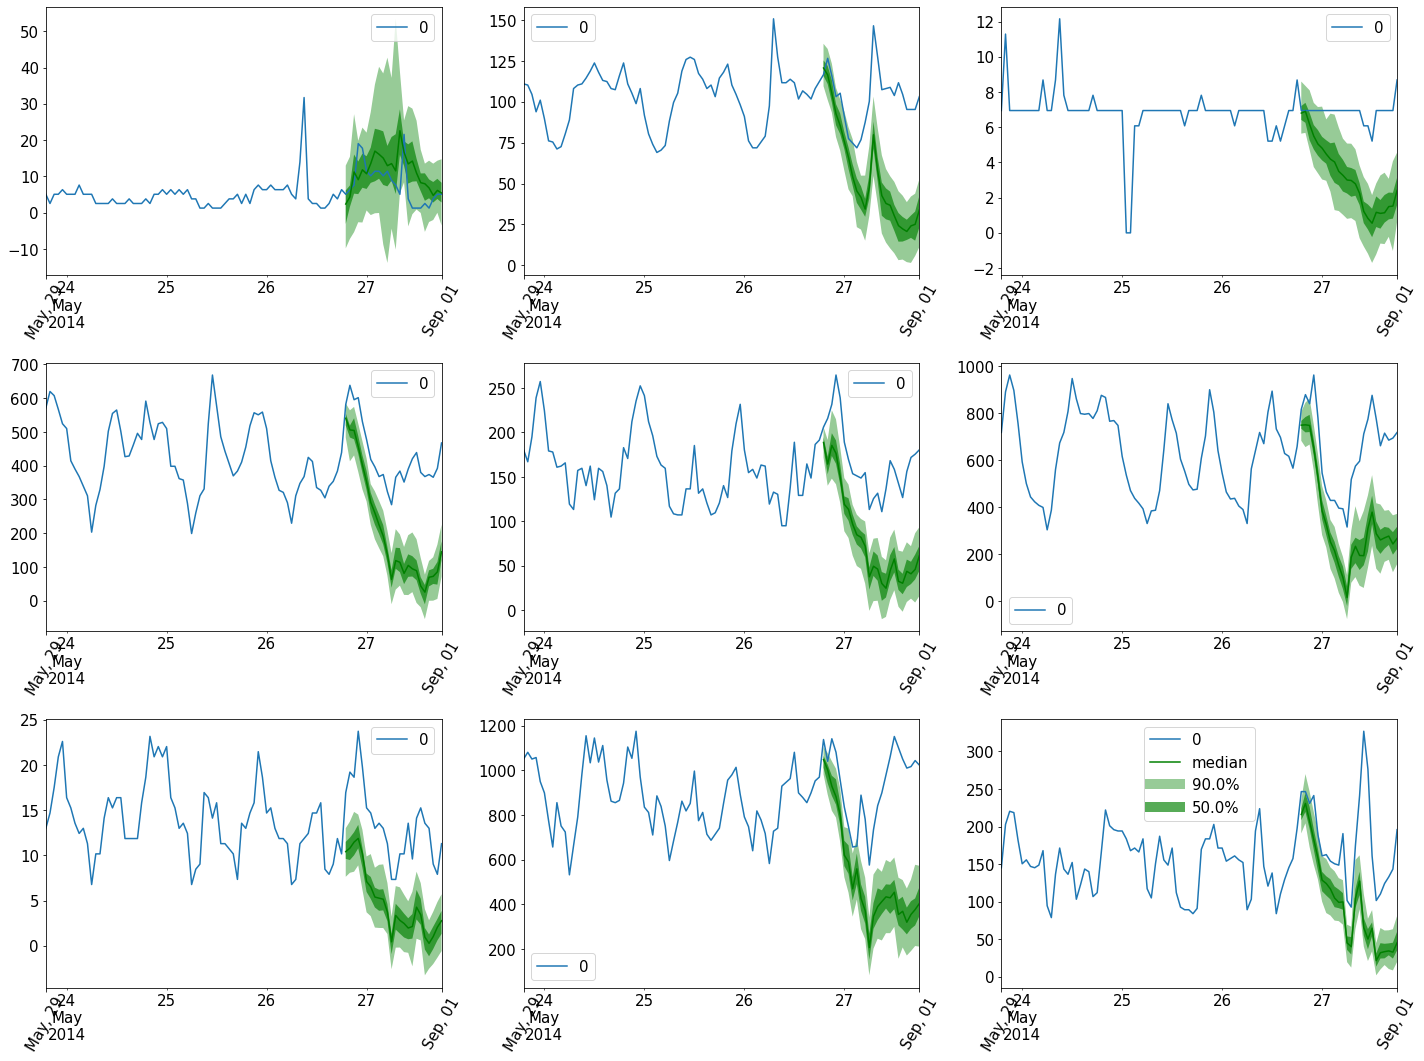

In [95]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    ts[-4 * prediction_length:].plot(ax=ax, label="target",)
    forecast.plot(color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)

plt.gcf().tight_layout()
plt.legend()
plt.show()